# Two visualizations of the unclustered data


Hierachical needs distances
Distance of Df, and Ds of the KS algorithm, either sepperatly or combine them somehow (addition?)

In [2]:
import numpy as np
import os
%matplotlib inline 
from matplotlib import pyplot as plt  

# Functions for easier folder access

In [3]:
#cwd = os.getcwd()
#print cwd
dirName = '/home/sven/ADA Dennis_Sven/P5-Clustering/GygiAnalysis/'
def getData(folderName):
    npzfilename=os.path.join(dirName + folderName,'rawFeatures.npz')
    dataRaw= np.load(npzfilename) 
    dataRaw=dataRaw['arr_0'].item()
    #dataraw.keys()
    return dataRaw

def compareData(nameFirst, nameSecond, attribute):
    arrayFirst = getData(nameFirst)[attribute]
    arraySecond = getData(nameSecond)[attribute]
    ks, p = stats.ks_2samp(arrayFirst.ravel(), arraySecond.ravel())
    return ks

def getDirList(inputBool):
    exclude = ['GygiDataAnalysis_PT', 'GygiDataAnalysis_TN', 'GygiDataAnalysis_PN', 'GygiDataAnalysis2DManual', '.ipynb_checkpoints']
    dirList = []
    for name in os.listdir(dirName):
        if os.path.isdir(os.path.join(dirName, name)):
            if name not in exclude:
#                 print name
                dirList.append(name)
    dirList.sort()
    if inputBool:
        return dirList[0:10]
    else:
        return dirList

# Visualizations

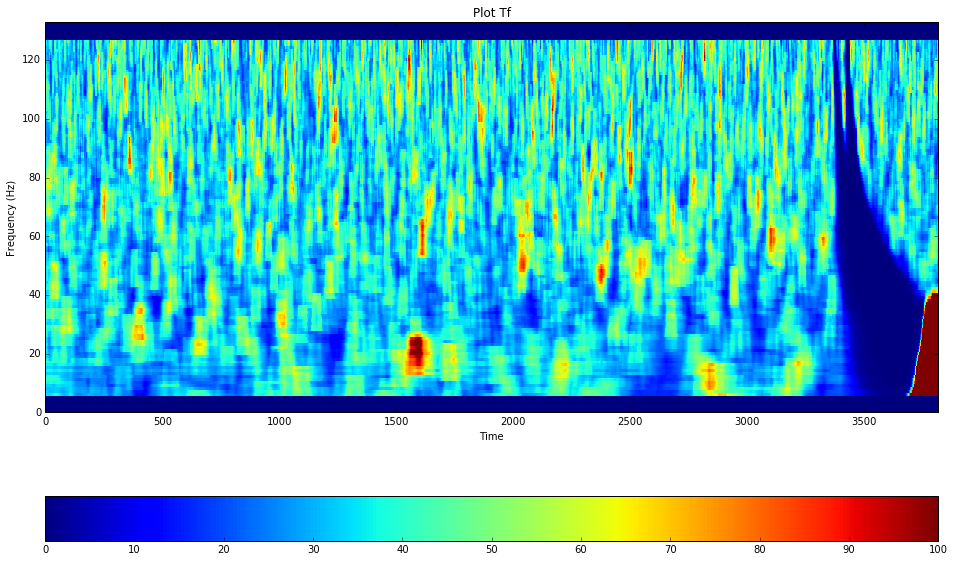

(133, 3816)


1240.2607913994066

In [4]:
array = getData('gun')
array = array['Tf']

fig = plt.figure(figsize=(16,10,))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(array, interpolation='nearest',aspect='auto', vmin = 0, vmax=100)
plt.title('Plot Tf')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(img, orientation='horizontal')
plt.ylim(0, 133) #Flipping Y so that 0 is at the bottom
plt.show()

#tijd is X, freq is Y, color is intensity van 0 tot 100 dB²
print array.shape
array[20][3800]

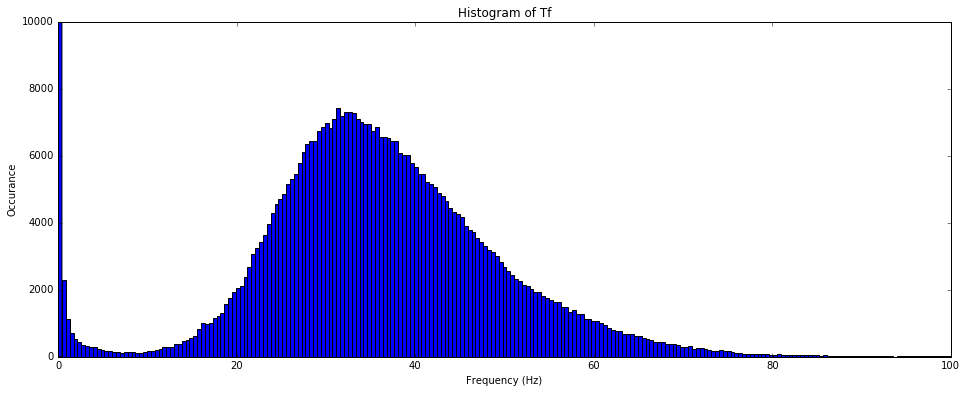

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,6,))
ax = fig.add_subplot(1,1,1)
plt.hist(array.ravel(), bins='auto', range=(0, 100))#Ravel makes a 1D array from a 2D, {{1,2}, {3,4}} = {1,2,3,4}
plt.title('Histogram of Tf')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Occurance')
plt.ylim(0, 10000)
plt.show()


# Analyzing data

According to Elburg, we should open each files "Tf, Ts, E" and compare those files with the probability distance

from scipy import stats
from IPython.display import clear_output

dirList = getDirList(False)
maxSize = len(dirList)
outputArray = np.zeros((maxSize, maxSize))
# outputArray.shape

for i, dir1 in enumerate(dirList):
    # the [i::] of the upper triangle could work, but then the index "j" doenst represent the correct value, therefore i+j
    for  j, dir2 in enumerate(dirList[i::]):
        outputArray[i][j+i] = compareData(dir1,dir2,'Tf')
        outputArray[j+i][i] = outputArray[i][j+i]
        clear_output()
        print 'dir1: ' + str(i) + '\tdir2: '+ str(j+i)


In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.spatial.distance as ssd

#Saving the data
#np.savez_compressed('dataArray.npz', outputArray)

In [7]:
npzfilename=os.path.join('/home/sven/ADA Dennis_Sven/Dennis_Sven/' + 'dataArray.npz')
dataRaw = np.load(npzfilename) 
dataRaw=dataRaw['arr_0']
#dataRaw.shape

(100, 100)


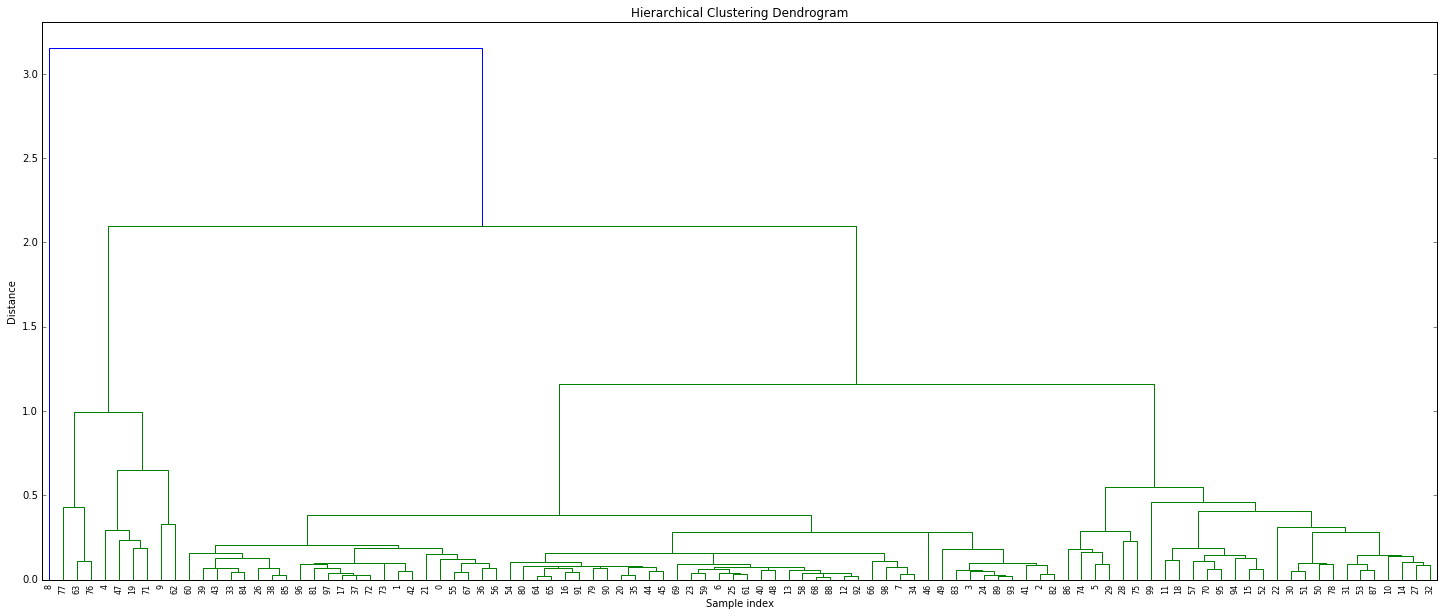

In [11]:
X = dataRaw
print X.shape
Z = linkage(X,'median')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

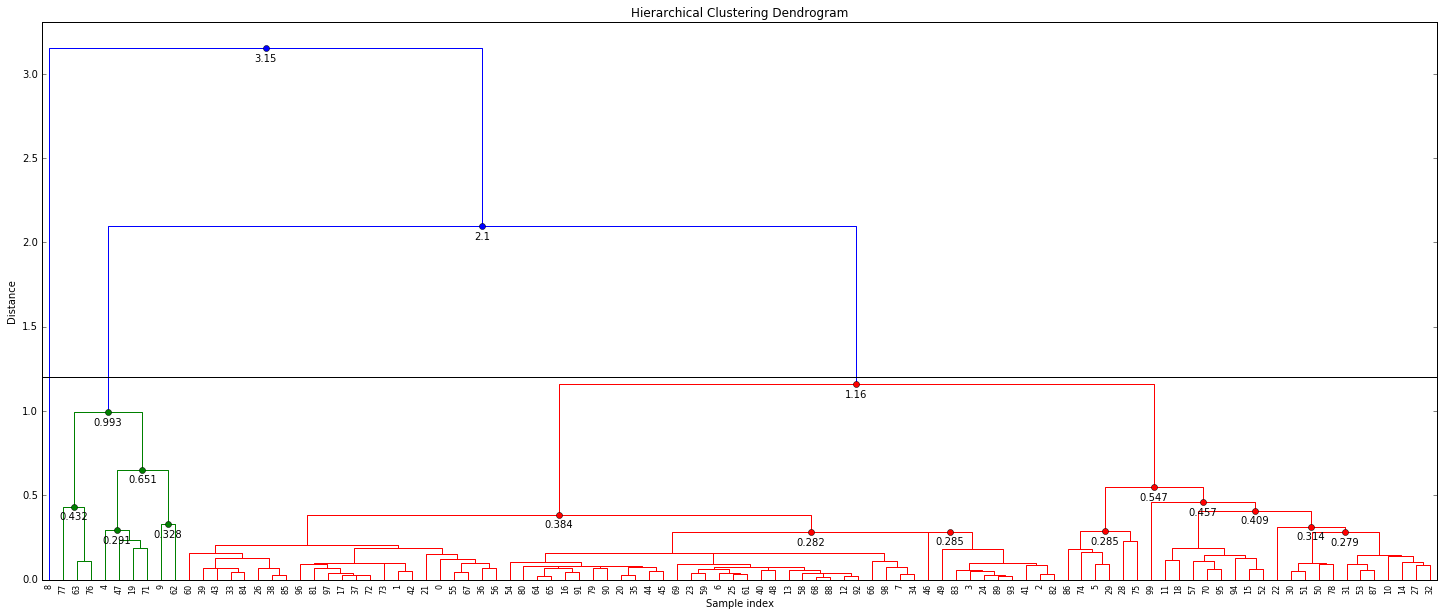

In [16]:
def dendrogram2(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    
    ddata = dendrogram(*args, **kwargs)
    
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Sample index')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata
plt.figure(figsize=(25, 10))

dendrogram2(
    Z,
    truncate_mode='lastp',
    p=100,
    show_leaf_counts=False,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True,
    annotate_above=0.25,
    max_d=1.2,
)
plt.show()

Choosing the numer of clusters (elbow methode)
----------------------------------------------


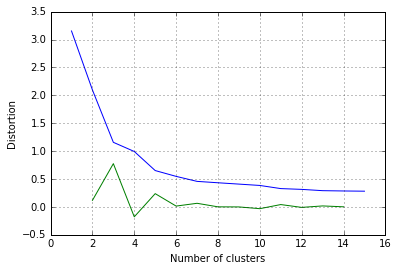

Ideal number of clusters by elbow methode =  3


In [17]:
last = Z[-15:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.grid(True)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "Ideal number of clusters by elbow methode = ", k

Posibility to change k manually:
--------------------------------

In [18]:
from scipy.cluster.hierarchy import fcluster
k=k
clusters = fcluster(Z, k, criterion='maxclust')
print "Used value for k = ", k

Used value for k =  3


Plotting the clustered data:
----------------------------


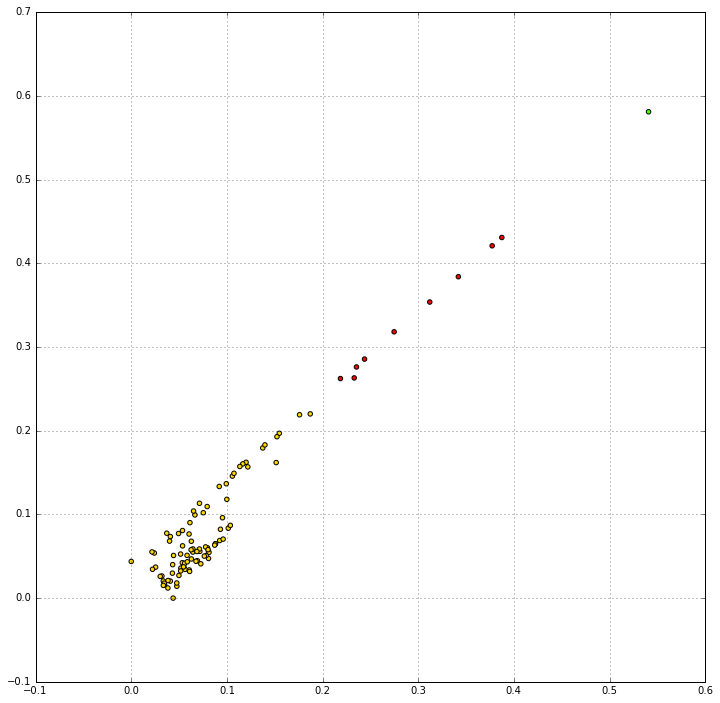

In [21]:
plt.figure(figsize=(12,12))
plt.scatter(X[:,0], X[:,1], c=clusters, cmap = 'prism')
plt.grid(True)
plt.show()

In [12]:
dirList = getDirList(False)
print dirList[52]

icedrop
